<a href="https://colab.research.google.com/github/CIA-Oceanix/DLOA2023/blob/main/lectures/notebooks/notebook_MNIST_AutoEncoder_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Auto-Encoders using pytorch


---



## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
     transforms.ToTensor(),
 ])


#train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
#test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 318673293.56it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97926995.82it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 156698570.22it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20244982.75it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



255

In [2]:
num_train, num_test = len(train_data), len(test_data) # TO DO
print('A =', num_train) # TO DO
print('B =', num_test) # TO DO
print('C =', train_data.data.shape[1]) # TO DO
print('D =', len(train_data.classes)) # TO DO

A = 60000
B = 10000
C = 28
D = 10


As indicated below, each Fashion-MNIST sample is assigned to one of the following classes: 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.

In [3]:
class_names = train_data.classes
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2
train_size = 0.3

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  nb_train = int( np.floor(train_size * num_train ))
  split = int(np.floor(valid_size * num_train))
  train_index, valid_index = indices[split:nb_train], indices[:split]

  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  return train_loader, valid_loader, test_loader

In [5]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

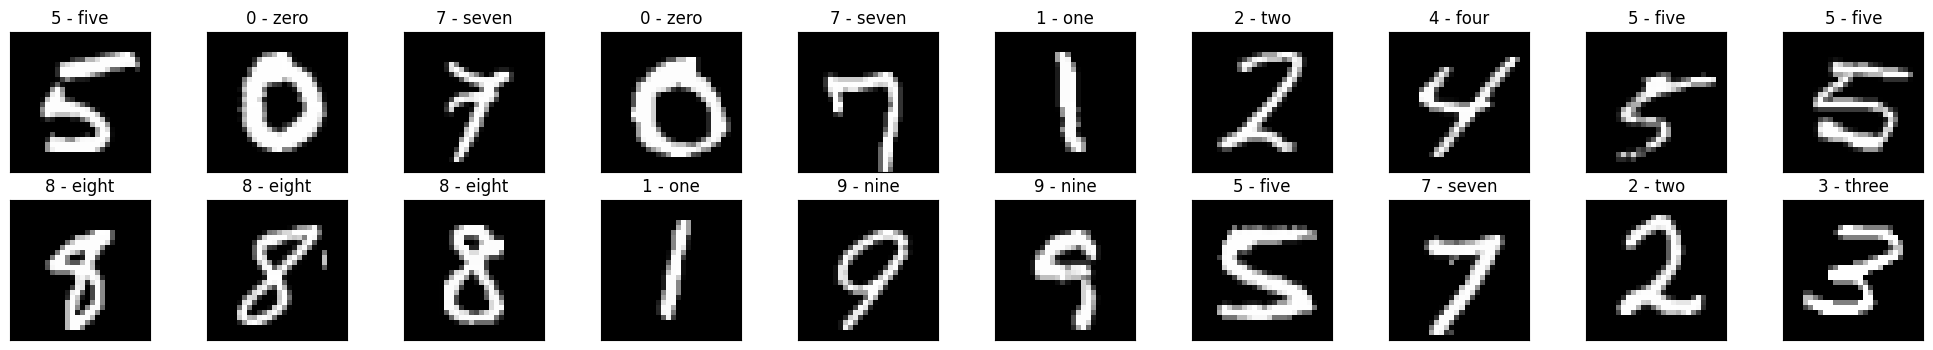

In [6]:
# CELL TO BE COMPLETED
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader)
images, labels = next( data_iter )
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(class_names[labels[idx].item()]))

### **Test and comparison to PCA**

In [7]:
dim_pca = 4

from sklearn.decomposition import PCA

#mse,test_recon = test_epoch(encoder,decoder,device,test_loader,loss_fn)
#mse

# learn PCA
X = train_data.data.reshape((train_data.data.shape[0],28*28))
pca = PCA(n_components=dim_pca)
pca.fit(X)

PCA(n_components=4)

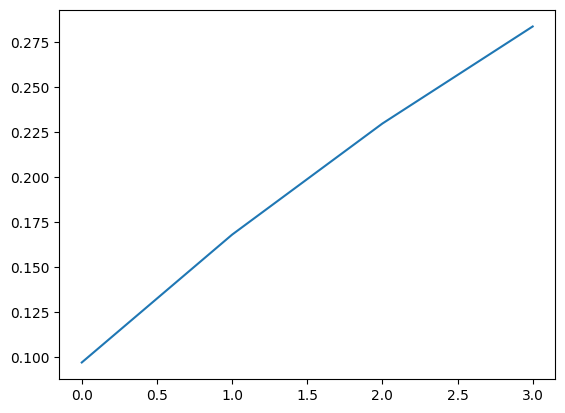

In [8]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [9]:
# apply PCA to test data
X = test_data.data.numpy()
X = X.reshape((test_data.data.shape[0],28*28))
out_pca = pca.inverse_transform( pca.transform(X) )
out_pca = out_pca.reshape((test_data.data.shape[0],28,28))
mse_pca = np.mean( (test_data.data.numpy() - out_pca) **2 )

var_exp_test = 1. - mse_pca / np.var( X[:] )
print('.... (PCA) Explained variance for test dataset = %.3f' %(100 * var_exp_test ))

.... (PCA) Explained variance for test dataset = 50.307


## 2-**MLP Auto-encoder architecture**

In [33]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=10,fc2_input_dim=10):
        super(Encoder,self).__init__()
        hidden_1, hidden_2 = fc2_input_dim , encoded_space_dim
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim=10,fc2_input_dim=10): # FUNCTION TO BE COMPLETED
        super(Decoder,self).__init__()
        hidden_1, hidden_2 = encoded_space_dim , fc2_input_dim
        self.fc1 = nn.Linear( hidden_1, fc2_input_dim)
        self.fc2 = nn.Linear(fc2_input_dim,28*28)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = # TODO apply fc2
        x = # reshape the output vector to an image tensor
        return x


## 2- **Convolutional Auto-Encoder architecture**

In [25]:
#import torch.nn as nn
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [34]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
dim_ae = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=dim_ae,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=dim_ae,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [35]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)

        #print( torch.mean(image_batch))
        #print( torch.max(image_batch))
        #print( torch.min(image_batch))

        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)

            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)

    return val_loss.data.item(),conc_out.numpy()

In [18]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_data.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_data[t_idx[i]][0].unsqueeze(0).to(device)

      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/10 	 train loss 0.060927849262952805 	 val loss 0.0496060810983181


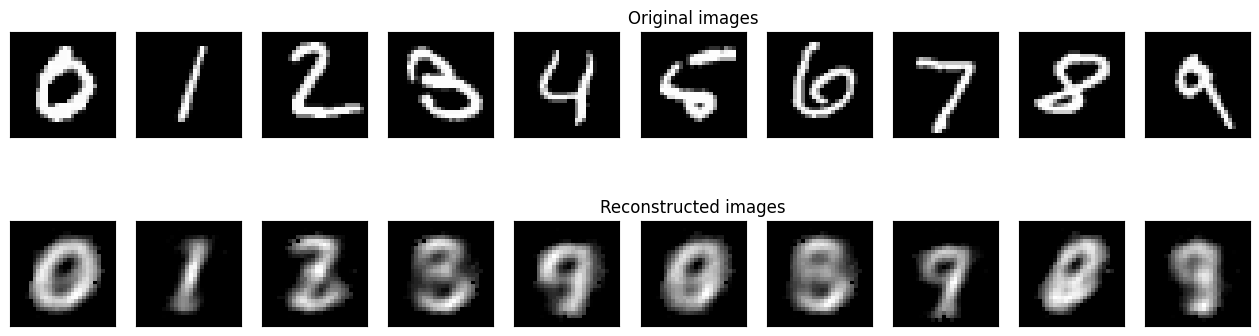


 EPOCH 2/10 	 train loss 0.050227090716362 	 val loss 0.04659687355160713


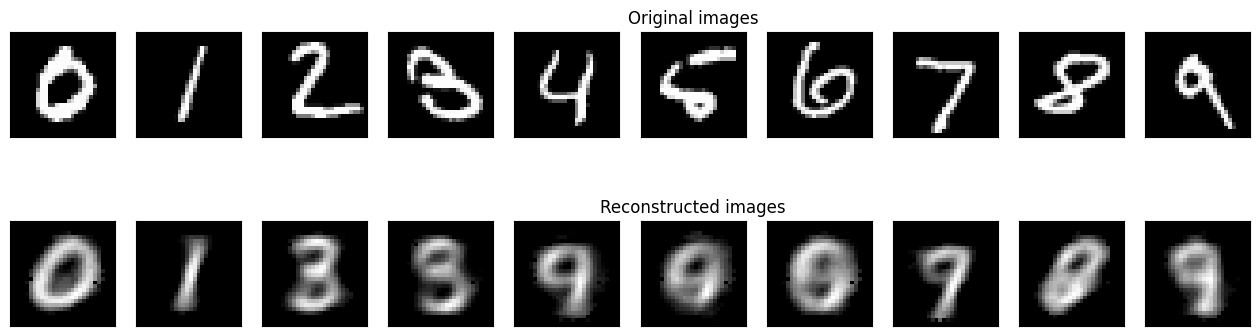


 EPOCH 3/10 	 train loss 0.048284098505973816 	 val loss 0.045537251979112625


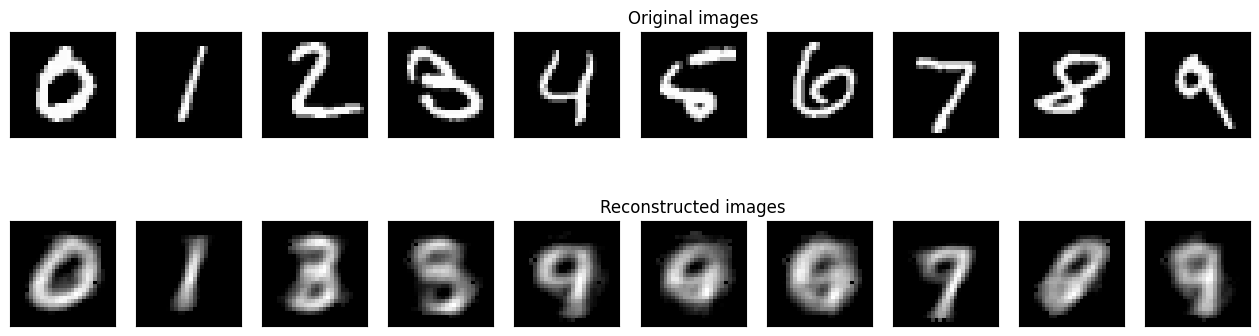


 EPOCH 4/10 	 train loss 0.047335103154182434 	 val loss 0.04451965168118477


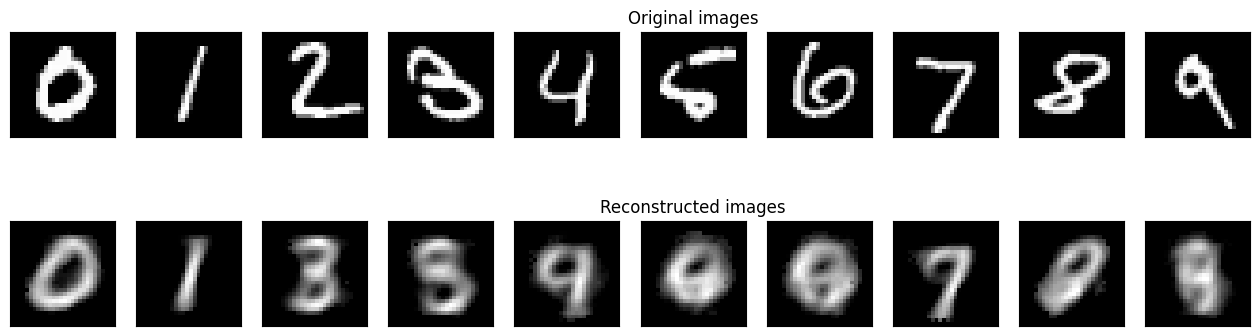


 EPOCH 5/10 	 train loss 0.046561602503061295 	 val loss 0.04428256303071976


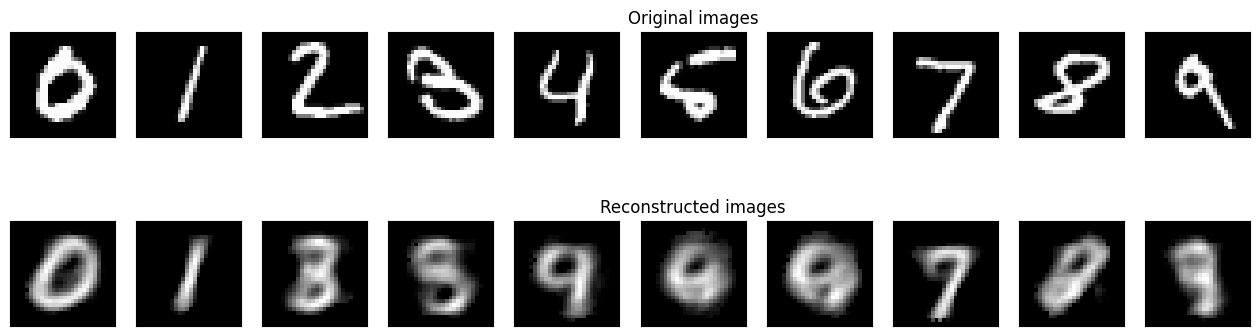


 EPOCH 6/10 	 train loss 0.046080805361270905 	 val loss 0.043700266629457474


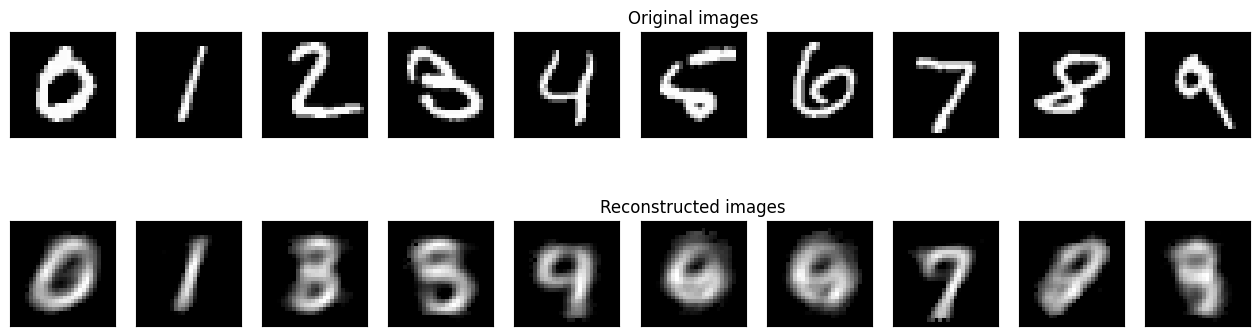


 EPOCH 7/10 	 train loss 0.04483586922287941 	 val loss 0.04108990728855133


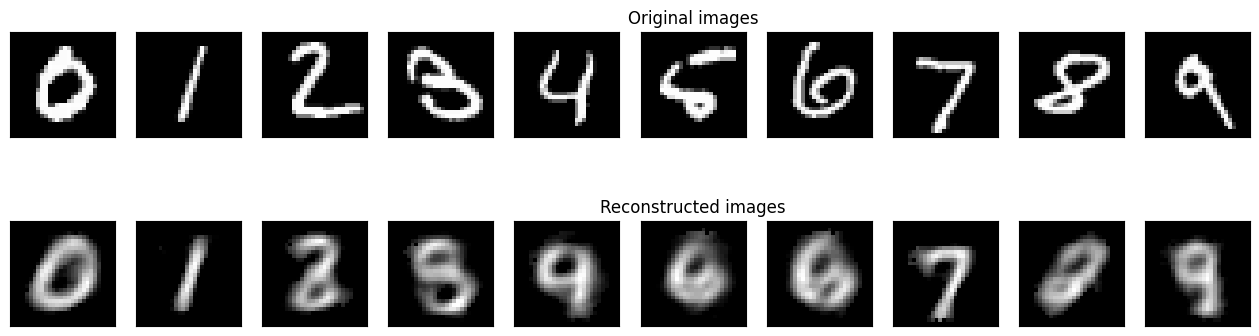


 EPOCH 8/10 	 train loss 0.04312283918261528 	 val loss 0.04000208526849747


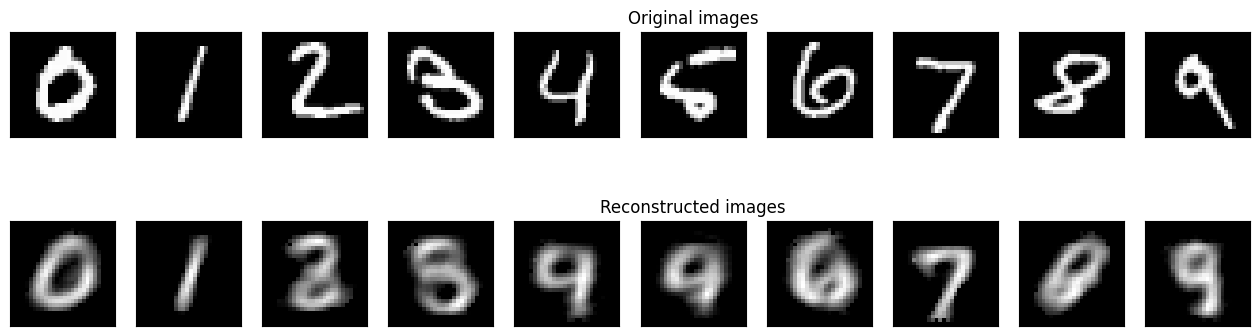


 EPOCH 9/10 	 train loss 0.042366091161966324 	 val loss 0.03937813639640808


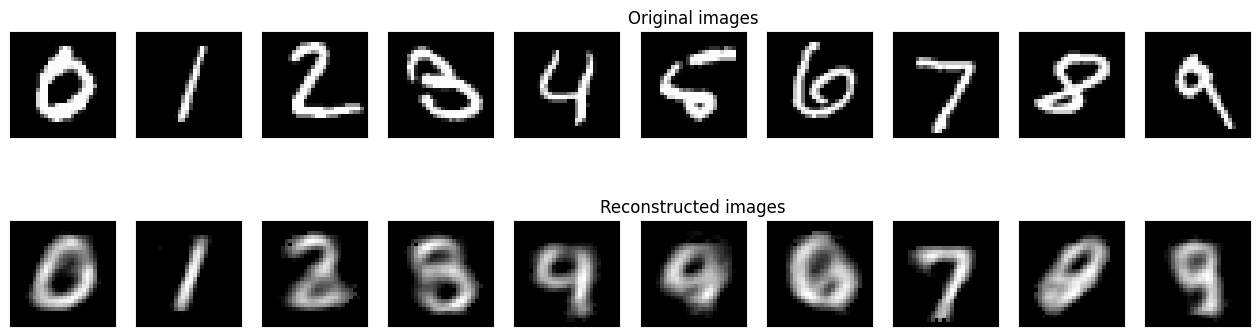


 EPOCH 10/10 	 train loss 0.0418475866317749 	 val loss 0.038599785417318344


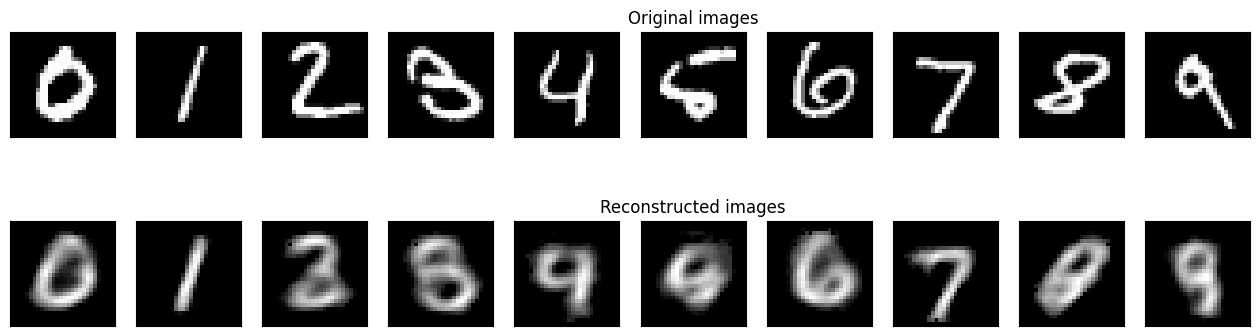

In [36]:
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)

   val_loss,out_ae = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

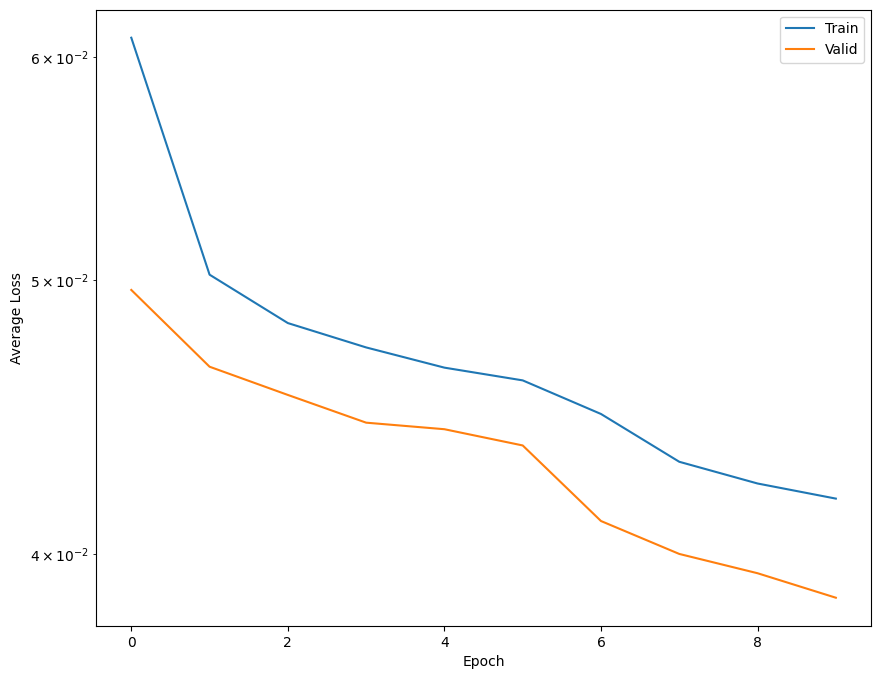

In [37]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [38]:
### Explained variance for the convolutional auto-encoder
val_loss,out_ae = test_epoch(encoder,decoder,device,test_loader,loss_fn)

# denormalization
#out_ae = 255 * out_ae

out_ae = out_ae.squeeze()
mse_convae = np.mean( (255 * out_ae - test_data.data.numpy())**2 )
mse_pca = np.mean( (out_pca - test_data.data.numpy())**2 )

var_exp_ae = 1. - mse_convae / np.var( test_data.data.numpy() )
var_exp_pca = 1. - mse_pca / np.var( test_data.data.numpy() )

print('....... Explained variance for test dataset ' )
print('... PCA (%d) = %.3f'%(dim_pca,100. * var_exp_pca))
print('... AE (%d) = %.3f'%(dim_ae,100. * var_exp_ae))


....... Explained variance for test dataset 
... PCA (4) = 50.307
... AE (4) = 59.958


# Generation of random images from latent codes

tensor([1.7264, 2.0557, 1.6492, 1.8399])
tensor([1.1989, 1.3655, 1.6068, 1.2673])


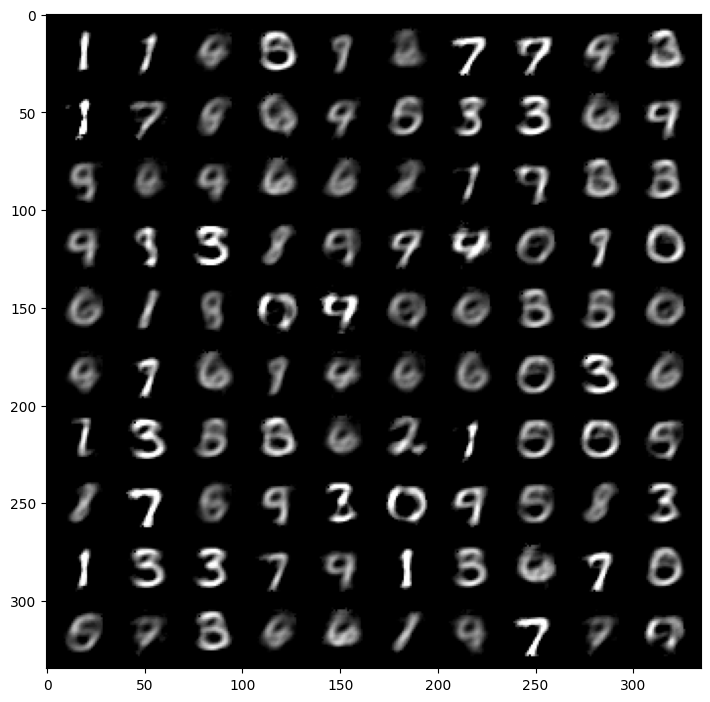

In [39]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs
    images, labels = next( iter(test_loader) )
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, dim_ae)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()